# Fingerprint Recognition

## Import library

* Python 3.11.7
* numpy 1.26.2
* matplotlib 3.8.2
* Tensorflow 2.15.0
* keras 2.12.0
* scikit-learn 1.3.2
* opencv-python 4.8.1.78
* scikit-image 0.22.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from dataset import DataSet 
from preprocess import Normalize, Image_segmentation, gabor_filter

## Import Data

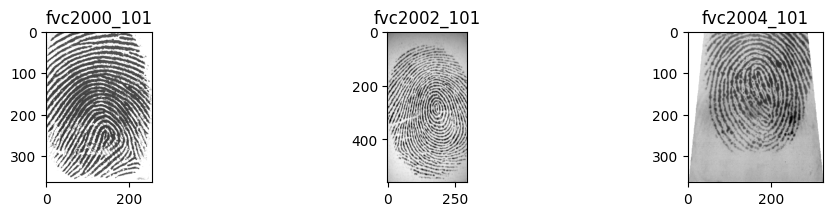

In [2]:
fvc2000 = DataSet(dataset_path = '../data/fvc2000', prefix_label='fvc2000', logging= False)
fvc2002 = DataSet(dataset_path = '../data/fvc2002', prefix_label='fvc2002', logging= False)
fvc2004 = DataSet(dataset_path = '../data/fvc2004', prefix_label='fvc2004', logging= False)

plt.figure(figsize=(12, 9))

plt.subplot(4, 3, 1)
plt.title(fvc2000.labels[0])
plt.imshow(fvc2000.images[0], cmap='gray')

plt.subplot(4, 3, 2)
plt.title(fvc2002.labels[0])
plt.imshow(fvc2002.images[0], cmap='gray')

plt.subplot(4, 3, 3)
plt.title(fvc2004.labels[0])
plt.imshow(fvc2004.images[0], cmap='gray')

## Preprocess


### Normalize

The purpose of this normalization stage is to reduce the grayscale variations between ridges and furrows, making subsequent processing stages more convenient. Normalization allows the adjustment of pixel intensity values to achieve a desired mean grayscale value and variance. This adjustment aims to minimize the differences in grayscale levels between the ridges and furrows, facilitating smoother processing in subsequent stages.

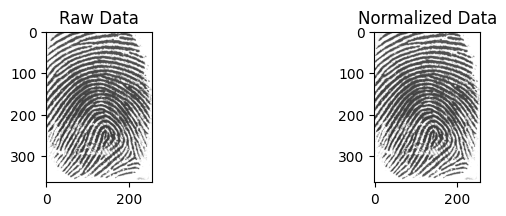

In [3]:
normalized_fvc2000 = np.array([Normalize(image, 0.5, 0.5) for image in fvc2000.images], dtype=float)
# normalized_fvc2002 = [Normalize(image, 0.5, 0.5) for image in fvc2002.images]
# normalized_fvc2004 = [Normalize(image, 0.5, 0.5) for image in fvc2004.images]

plt.figure(figsize=(12, 9))

plt.subplot(4, 3, 1)
plt.title("Raw Data")
plt.imshow(fvc2000.images[0], cmap='gray')

plt.subplot(4, 3, 2)
plt.title("Normalized Data")
plt.imshow(normalized_fvc2000[0], cmap='gray')

### Segmentation

Phân vùng ảnh là chọn ra được vùng ảnh vân tay cần quan tâm dùng cho việc nhận dạng, bao gồm các đường vân và rãnh rõ ràng.

 230 229 
 230 229 
 230 229 


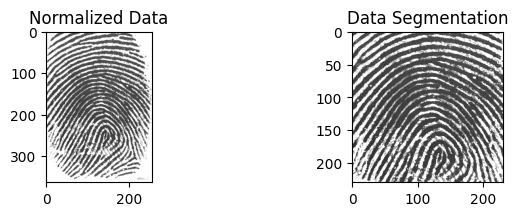

In [4]:
segmented_fvc2000 = np.array([Image_segmentation(image, 192, 192) for image in normalized_fvc2000], dtype=float)
# segmented_fvc2002 = [Image_segmentation(image, 192, 192) for image in normalized_fvc2002]
# segmented_fvc2004 = [Image_segmentation(image, 192, 192) for image in normalized_fvc2004]

plt.figure(figsize=(12, 9))

plt.subplot(4, 3, 1)
plt.title("Normalized Data")
plt.imshow(normalized_fvc2000[0], cmap='gray')

plt.subplot(4, 3, 2)
plt.title("Data Segmentation")
plt.imshow(segmented_fvc2000[0], cmap='gray')

### Gabor filter

Frequency (frequency_value): Giá trị tần số cao sẽ tạo ra các chi tiết nhỏ và giúp phát hiện các đặc điểm nhỏ trong ảnh vân tay. Trong khi đó, tần số thấp sẽ tập trung vào các đặc điểm lớn hơn và tạo ra các cấu trúc tổng thể rõ ràng hơn. Thử nghiệm với các giá trị khác nhau như 0.1, 0.5, 1.0, 2.0 và quan sát sự thay đổi trong kết quả để chọn giá trị phù hợp.

Orientation (orientation_theta): Hướng này định hình hướng của các đường vân tay. Thử nghiệm với các góc khác nhau như 0, π/4, π/2, π để xem góc nào giúp làm rõ các đặc điểm vân tay một cách tốt nhất.

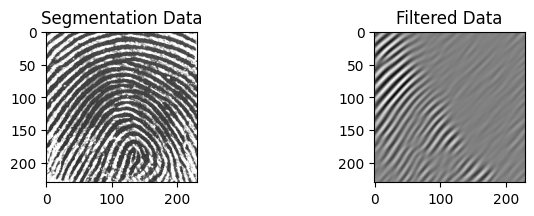

In [5]:
frequency_value = 0.1  # Adjust frequency value as needed
orientation_theta = np.pi / 4  # Adjust orientation angle (in radians) as needed

filtered_fvc2000 = np.array([gabor_filter(image, frequency_value, orientation_theta) for image in segmented_fvc2000], dtype=float)
# filtered_fvc2002 = [gabor_filter(image, frequency_value, orientation_theta) for image in segmented_fvc2002]
# filtered_fvc2004 = [gabor_filter(image, frequency_value, orientation_theta) for image in segmented_fvc2004]

plt.figure(figsize=(12, 9))

plt.subplot(4, 3, 1)
plt.title("Segmentation Data")
plt.imshow(segmented_fvc2000[0], cmap='gray')

plt.subplot(4, 3, 2)
plt.title("Filtered Data")
plt.imshow(filtered_fvc2000[0], cmap='gray')

## Merge & Split Train/ Test Data

In [50]:
data = np.concatenate([filtered_fvc2000], axis=0)
labels = np.concatenate([fvc2000.labels], axis=0)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.1)

print(data.size)

4232000


## Train


In [51]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Tạo mô hình mạng nơ-ron
model = Sequential([
    Flatten(input_shape=train_data.shape[1:]),  # Dữ liệu ảnh, chuyển thành vector
    Dense(128, activation='relu'),  # Layer ẩn có 128 units, sử dụng hàm kích hoạt ReLU
    Dense(10, activation='softmax')  # Layer output với 10 units (ví dụ: phân loại 10 lớp), softmax để phân phối xác suất
])

# Compile model với optimizer, loss function và metrics
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
num_epochs = 10  # Số epoch (vòng lặp qua toàn bộ dữ liệu huấn luyện)
batch_size = 32  # Kích thước mini-batch
model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size, validation_split=0.1)

Model: "model_33"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_79 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 input_80 (InputLayer)          [(None, 90, 90, 1)]  0           []                               
                                                                                                  
 model_32 (Functional)          (None, 45, 45, 32)   160         ['input_79[0][0]',               
                                                                  'input_80[0][0]']               
                                                                                                  
 subtract_15 (Subtract)         (None, 45, 45, 32)   0           ['model_32[0][0]',        

__________________________________________________________________________________________________
Epoch 1/15


ValueError: in user code:

    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_33" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 230, 230) dtype=float32>]


### Evaluation

In [ ]:
import random
# new user fingerprint input
random_idx = random.randint(0, len(test_data))

random_img = test_data[random_idx]
random_label = test_label[random_idx]

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')